<a href="https://colab.research.google.com/github/talha1503/Zero-DCE/blob/main/Zero_DCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [73]:
IMG_SHAPE = (256,256)
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 35
LEARNING_RATE = 1e-3  
COLOR_LOSS_WEIGHT = 5
SMOOTHNESS_LOSS_WEIGHT = 20  
TRAIN_VAL_SPLIT = 0.95  

In [74]:
train_data_transform = transforms.Compose([transforms.Resize(IMG_SHAPE),transforms.ToTensor()])
valid_data_transform = transforms.Compose([transforms.Resize(IMG_SHAPE),transforms.ToTensor()])

data_link = '/content/drive/My Drive/train_data_Zero-DCE/train_data'
total_image_list = os.listdir(data_link)

shuffle = np.random.permutation(len(total_image_list))
split_values = int(len(total_image_list) * TRAIN_VAL_SPLIT)

print("Total images: ",len(total_image_list))
print("Validation Data: ",len(shuffle[split_values:]))
print("Training Data: ",len(shuffle[:split_values]))

class TrainDataset(torch.utils.data.Dataset):
  def __init__(self,image_shape,transforms):
    self.image_list = np.array([total_image_list[i] for i in shuffle[:split_values]])
    self.image_shape = image_shape 
    self.transform = transforms

  def __len__(self):
    return len(self.image_list) 

  def __getitem__(self,index):
    image = self.image_list[index]
    image = Image.open(data_link + '/' + image)
    transformed_image = self.transform(image)
    normalized_image = transformed_image/255
    return normalized_image

class ValidDataset(torch.utils.data.Dataset):
  def __init__(self,image_shape,transforms):
    self.image_list = np.array([total_image_list[i] for i in shuffle[split_values:]])
    self.image_shape = image_shape 
    self.transform = transforms

  def __len__(self):
    return len(self.image_list) 

  def __getitem__(self,index):
    image = self.image_list[index]
    image = Image.open(data_link + '/' + image)
    transformed_image = self.transform(image)
    normalized_image = transformed_image/255
    return normalized_image
  
train_dataset = TrainDataset(IMG_SHAPE,train_data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = TRAIN_BATCH_SIZE,shuffle=True)
valid_dataset = ValidDataset(IMG_SHAPE,valid_data_transform)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size = VALID_BATCH_SIZE,shuffle=True)

Total images:  2003
Validation Data:  101
Training Data:  1902


In [75]:
class DCENet(nn.Module):
  def __init__(self):  # Input ->  256x256x3
    super(DCENet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, stride = 1, padding = 1,bias = True)
    self.conv2 = nn.Conv2d(in_channels = 32 , out_channels = 32, kernel_size = 3, stride = 1, padding = 1,bias = True)
    self.conv3 = nn.Conv2d(in_channels = 32 , out_channels = 32, kernel_size = 3, stride = 1, padding = 1,bias = True)
    self.conv4 = nn.Conv2d(in_channels = 32 , out_channels = 32, kernel_size = 3, stride = 1, padding = 1,bias = True) 
    self.conv5 = nn.Conv2d(in_channels = 64 , out_channels = 32, kernel_size = 3, stride = 1, padding = 1,bias = True)
    self.conv6 = nn.Conv2d(in_channels = 64 , out_channels = 32, kernel_size = 3, stride = 1, padding = 1,bias = True)
    self.conv7 = nn.Conv2d(in_channels = 64 , out_channels = 24, kernel_size = 3, stride = 1, padding = 1,bias = True)
    

  def forward(self,input):
    output1 = F.relu(self.conv1(input))
    output2 = F.relu(self.conv2(output1))  
    output3 = F.relu(self.conv3(output2))
    output4 = F.relu(self.conv4(output3))
    output5 = F.relu(self.conv5(torch.cat([output3,output4],1)))   
    output6 = F.relu(self.conv6(torch.cat([output2,output5],1)))   
    output7 = F.tanh(self.conv7(torch.cat([output1,output6],1)))  # Output here is 256x256x24.   

    LE_curves = list(torch.split(output7,3,dim=1))  
    for i in range(8):
        input = input + LE_curves[i]*(torch.pow(input,2)-input)

    LE_curves = torch.cat(LE_curves,1)

    return input,LE_curves

In [76]:
class SpatialConsistencyLoss(nn.Module):
  def __init__(self):
    super(SpatialConsistencyLoss, self).__init__()
    self.left_kernel = torch.FloatTensor([[0,0,0],[-1,1,0],[0,0,0]]).unsqueeze(0).unsqueeze(0)
    self.top_kernel = torch.FloatTensor([[0,-1,0],[0,1,0],[0,0,0]]).unsqueeze(0).unsqueeze(0)
    self.right_kernel = torch.FloatTensor([[0,0,0],[0,1,-1],[0,0,0]]).unsqueeze(0).unsqueeze(0)
    self.bottom_kernel = torch.FloatTensor([[0,0,0],[0,1,0],[0,-1,0]]).unsqueeze(0).unsqueeze(0) 
    self.left_kernel = self.left_kernel.to(device)
    self.top_kernel = self.top_kernel.to(device)
    self.right_kernel = self.right_kernel.to(device)
    self.bottom_kernel = self.bottom_kernel.to(device)

  def forward(self,input_image,enhanced_image):
    mean_input = torch.mean(input_image,dim=1,keepdims=True)
    mean_enhanced = torch.mean(enhanced_image,dim=1,keepdims=True)    
    pool_input = F.avg_pool2d(input = mean_input,kernel_size = 4)
    pool_enhanced = F.avg_pool2d(input = mean_enhanced, kernel_size = 4)
    left_input = F.conv2d(pool_input,self.left_kernel,padding = 1)
    right_input = F.conv2d(pool_input,self.right_kernel,padding = 1)
    top_input = F.conv2d(pool_input,self.top_kernel,padding = 1)
    bottom_input = F.conv2d(pool_input,self.bottom_kernel,padding = 1)
    left_enhanced = F.conv2d(pool_enhanced,self.left_kernel,padding = 1)
    right_enhanced = F.conv2d(pool_enhanced,self.right_kernel,padding = 1)
    top_enhanced = F.conv2d(pool_enhanced,self.top_kernel,padding = 1)
    bottom_enhanced = F.conv2d(pool_enhanced,self.bottom_kernel,padding = 1)
    return torch.mean(torch.pow(left_enhanced-left_input,2) + torch.pow(right_enhanced-right_input,2) + torch.pow(top_enhanced-top_input,2) + torch.pow(bottom_enhanced-bottom_input,2))

class ExposureControlLoss(nn.Module):
  def __init__(self,E=0.6):
    super(ExposureControlLoss,self).__init__() 
    self.E = E

  def forward(self,enhanced_image):
    enhanced_image = torch.mean(enhanced_image,1,keepdims=True)
    val = F.avg_pool2d(enhanced_image,kernel_size = 16,stride = 16)  
    # E_matrix  = self.E*torch.ones(val.shape,device = device) # My equation
    return torch.mean(torch.pow(val - torch.FloatTensor([self.E]).to(device),2))   # Author's equation.

class ColorConstancyLoss(nn.Module):
  def __init__(self,colour_weight = COLOR_LOSS_WEIGHT):
    super(ColorConstancyLoss,self).__init__()
    self.colour_weight = colour_weight

  def forward(self,enhanced_image): 
    mean_enhanced = torch.mean(enhanced_image,[2,3],keepdims=True)
    splits = torch.split(mean_enhanced,1,dim=1)
    R = splits[0]
    G = splits[1]
    B = splits[2]
    # total = torch.pow(R-G,2) + torch.pow(B-G,2) + torch.pow(B-R,2) # My equation
    total = torch.pow(torch.pow(torch.pow(R-G,2),2) + torch.pow(torch.pow(R-B,2),2) + torch.pow(torch.pow(B-G,2),2),0.5) # Author's implementation varies from the paper.
    return self.colour_weight*torch.mean(total) 


class IlluminationSmoothnessLoss(nn.Module):
  def __init__(self,smoothness = SMOOTHNESS_LOSS_WEIGHT,):
    super(IlluminationSmoothnessLoss,self).__init__()
#     self.smoothness = smoothness

  def forward(self,curves):
    horizontal_gradients = torch.pow(curves[:,:,1:,:] - curves[:,:,:curves.shape[2]-1,:],2).sum() 
    vertical_gradients = torch.pow(curves[:,:,:,1:] - curves[:,:,:,:curves.shape[3]-1],2).sum()
    # total = (vertical_gradients + horizontal_gradients)/8   # My equation
    total = 2*(vertical_gradients/ (curves.shape[2] * (curves.shape[3] - 1)) + (horizontal_gradients/(curves.shape[2]-1) * curves.shape[3]))/curves.shape[0]
    return total


In [77]:
model = DCENet()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=LEARNING_RATE)

In [78]:
def train(train_iterator,valid_iterator,epochs,model,optimizer): 
  spatial_loss = SpatialConsistencyLoss()
  exposure_loss = ExposureControlLoss()
  colour_loss = ColorConstancyLoss()
  illumination_loss = IlluminationSmoothnessLoss()

  train_loss_list = []
  valid_loss_list = []

  for epoch in range(epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0
    for train_iteration,image in enumerate(train_iterator):
      model.train()
      optimizer.zero_grad()
      image = image.to(device)
      output,curves = model(image)
      
      loss = spatial_loss(image,output)  + 10*exposure_loss(output)  + colour_loss(output) + illumination_loss(curves)
      loss.backward()
      optimizer.step()
      train_epoch_loss += loss.item()

    for val_iteration,image in enumerate(valid_iterator):
      model.eval()
      image = image.to(device)
      output,curves = model(image)
      val_loss = spatial_loss(image,output) + 10*exposure_loss(output) + colour_loss(output) + 200*illumination_loss(curves)
      val_epoch_loss += val_loss.item() 

    train_loss_list.append(train_epoch_loss)
    valid_loss_list.append(val_epoch_loss)
    print("-"*50)
    print("Train Loss at epoch:{} is {} ".format(epoch,train_epoch_loss/len(train_iterator)))
    print("Valid Loss at epoch:{} is {} ".format(epoch,val_epoch_loss/len(valid_iterator)))
    print("-"*50)
  

  return model,train_loss_list,valid_loss_list

In [79]:
model,train_loss_list,valid_loss_list = train(train_loader,valid_loader,EPOCHS,model,optimizer)
torch.save(model,'/content/drive/My Drive/Zero-DCEModels/model_15.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


--------------------------------------------------
Train Loss at epoch:0 is 3.643341083486541 
Valid Loss at epoch:0 is 3.585906505584717 
--------------------------------------------------
--------------------------------------------------
Train Loss at epoch:1 is 3.5913184049750577 
Valid Loss at epoch:1 is 3.5923867225646973 
--------------------------------------------------
--------------------------------------------------
Train Loss at epoch:2 is 3.5882208617795417 
Valid Loss at epoch:2 is 3.5917270183563232 
--------------------------------------------------
--------------------------------------------------
Train Loss at epoch:3 is 3.5862167352387884 
Valid Loss at epoch:3 is 3.5856595039367676 
--------------------------------------------------
--------------------------------------------------
Train Loss at epoch:4 is 3.5847244673416396 
Valid Loss at epoch:4 is 3.586408853530884 
--------------------------------------------------
-------------------------------------------

In [80]:
def plot_list(loss_list):
  plt.plot(loss_list)
  plt.show()

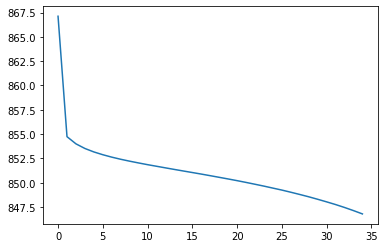

In [81]:
plot_list(train_loss_list)

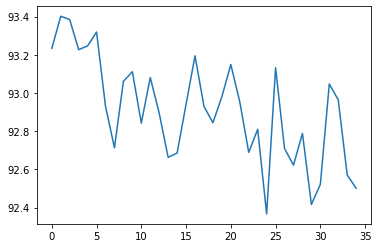

In [82]:
plot_list(valid_loss_list)

In [83]:
test_data_transform = transforms.Compose([transforms.Resize(IMG_SHAPE),transforms.ToTensor()])
save_directory = '/content/drive/My Drive/ZeroDCEResult/'

class TestDataset(torch.utils.data.Dataset):
  def __init__(self,image_shape,transforms,image_path, image_directory):
    self.image_list = [image_path]
    self.image_shape = image_shape 
    self.transform = transforms
    self.image_directory = image_directory

  def __len__(self):
    return len(self.image_list) 

  def __getitem__(self,index):
    image = self.image_list[index]
    image = Image.open(self.image_directory + '/' + image)
    transformed_image = self.transform(image)
    normalized_image = transformed_image/255
    return normalized_image

def eval(image_name,image_directory,model_path):
  test_dataset = TestDataset(IMG_SHAPE,test_data_transform,image_name, image_directory)
  test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 1,shuffle=True)
  image = next(iter(test_loader))
  image = image.to(device)
  model = torch.load(model_path)
  model.to(device)
  output,curves = model(image)
  output = output*255
  output = output[0]

  save_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=256),
    transforms.ToTensor()
  ])

  torchvision.utils.save_image(output,save_directory+image_name)

for i in range(1,11):
  eval('LIME/{}.bmp'.format(i),'/content/drive/My Drive/ZeroDCEtest/','/content/drive/My Drive/Zero-DCEModels/model_15.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
